In [2]:
 %tensorflow_version 1.x
import tensorflow as tf
import sys, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym
from gym.core import Wrapper
from gym.spaces.box import Box
import cv2


In [3]:
class PreprocessAtari(Wrapper):
    def __init__(self, env, height=42, width=42, color=False,
                 crop=lambda img: img, n_frames=4, dim_order='pytorch', reward_scale=1):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(PreprocessAtari, self).__init__(env)
        self.img_size = (height, width)
        self.crop = crop
        self.color = color
        self.dim_order = dim_order

        self.reward_scale = reward_scale
        n_channels = (3 * n_frames) if color else n_frames

        obs_shape = {
            'theano': (n_channels, height, width),
            'pytorch': (n_channels, height, width),
            'tensorflow': (height, width, n_channels),
        }[dim_order]

        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """Resets the game, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """Plays the game for 1 step, returns frame buffer"""
        new_img, r, done, info = self.env.step(action)
        self.update_buffer(new_img)

        return self.framebuffer, r * self.reward_scale, done, info

    ### image processing ###

    def update_buffer(self, img):
        img = self.preproc_image(img)
        offset = 3 if self.color else 1
        if self.dim_order == 'tensorflow':
            axis = -1
            cropped_framebuffer = self.framebuffer[:, :, :-offset]
        else:
            axis = 0
            cropped_framebuffer = self.framebuffer[:-offset, :, :]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis=axis)

    def preproc_image(self, img):
        """what happens to the observation"""
        img = self.crop(img)
        img = cv2.resize(img / 255, self.img_size, interpolation=cv2.INTER_LINEAR)
        if not self.color:
            img = img.mean(-1, keepdims=True)
        if self.dim_order != 'tensorflow':
            img = img.transpose([2, 0, 1])  # [h, w, c] to [c, h, w]
        return img


In [4]:



def make_env():
    env = gym.make("KungFuMasterDeterministic-v0")
    env = PreprocessAtari(
        env, height=42, width=42,
        crop=lambda img: img[60:-30, 5:],
        dim_order='tensorflow',
        color=False, n_frames=4)
    return env

env = make_env()

obs_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation shape:", obs_shape)
print("Num actions:", n_actions)
print("Action names:", env.env.env.get_action_meanings())

Observation shape: (42, 42, 4)
Num actions: 14
Action names: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'DOWNRIGHT', 'DOWNLEFT', 'RIGHTFIRE', 'LEFTFIRE', 'DOWNFIRE', 'UPRIGHTFIRE', 'UPLEFTFIRE', 'DOWNRIGHTFIRE', 'DOWNLEFTFIRE']


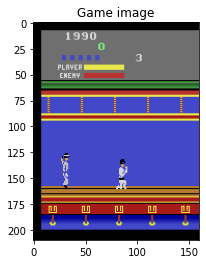

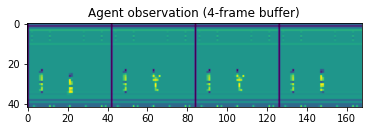

In [5]:
s = env.reset()
for _ in range(100):
    s, _, _, _ = env.step(env.action_space.sample())

plt.title('Game image')
plt.imshow(env.render('rgb_array'))
plt.show()

plt.title('Agent observation (4-frame buffer)')
plt.imshow(s.transpose([0, 2, 1]).reshape([42,-1]))
plt.show()

In [6]:

tf.reset_default_graph()
sess = tf.InteractiveSession()

In [7]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Flatten, Input

Using TensorFlow backend.


In [8]:
class Agent:
    def __init__(self, name, state_shape, n_actions, reuse=False):
        """A simple actor-critic agent"""
        
        with tf.variable_scope(name, reuse=reuse):
            
            # Prepare neural network architecture
            #<YOUR CODE: prepare any necessary layers, variables, etc.>




            input=Input(shape=state_shape)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(input)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(x)
            x = Conv2D(32, (3, 3), strides=2, activation='relu')(x)
            x=Flatten()(x)
            x=Dense(128, activation='relu')(x)

            state_value=Dense(1,activation='relu')(x)
            logits=Dense(n_actions,activation='relu')(x)



            self.network=Model(inputs=input,outputs=[state_value,logits])








            
            # prepare a graph for agent step
            self.state_t = tf.placeholder('float32', [None,] + list(state_shape))
            self.agent_outputs = self.symbolic_step(self.state_t)
        
    def symbolic_step(self, state_t):
        """Takes agent's previous step and observation, returns next state and whatever it needs to learn (tf tensors)"""
        
        # Apply neural network
        #<YOUR CODE: apply the agent's neural network to get policy logits and state values>


        state_v,logit=self.network(state_t)



        
        logits = logit
        state_values =state_v[:,0]
        
        assert tf.is_numeric_tensor(logits) and logits.shape.ndims == 2, \
            "Please return 2D TF tensor of logits [you got %s]." % repr(logits)
        assert tf.is_numeric_tensor(state_values) and state_values.shape.ndims == 1, \
            "Please return 1D TF tensor of state values [you got %s]." % repr(state_values)
        # Hint: if you triggered state_values assert with your shape being [None, 1],
        # just select [:, 0]-th element of state values as new state values.
        # Alternatively, you can do tf.squeeze(state_values, axis=1).
        
        return logits, state_values
    
    def step(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.get_default_session()
        return sess.run(self.agent_outputs, {self.state_t: state_t})
    
    def sample_actions(self, agent_outputs):
        """pick actions given numeric agent outputs (np arrays)"""
        logits, state_values = agent_outputs
        policy = np.exp(logits) / np.sum(np.exp(logits), axis=-1, keepdims=True)
        return np.array([np.random.choice(len(p), p=p) for p in policy])

In [9]:
 agent = Agent("agent", obs_shape, n_actions)
sess.run(tf.global_variables_initializer())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
state = [env.reset()]
logits, value = agent.step(state)
print("action logits:\n", logits)
print("state values:\n", value)

action logits:
 [[0.02990367 0.         0.         0.0480407  0.         0.
  0.00125481 0.00495485 0.00170961 0.00121928 0.03024399 0.
  0.04882964 0.04621806]]
state values:
 [0.]


In [12]:
import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    final_rewards = evaluate(agent, env_monitor, n_games=3)

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
from google.colab import files
files.download(video_names[-2]) 

print(final_rewards)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-490729231edb>", line 6, in <module>
    video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
NameError: name 'Path' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/l

NameError: ignored

In [ ]:
from google.colab import files
files.download(video_names[-2]) 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
class EnvBatch:
    def __init__(self, n_envs = 10):
        """ Creates n_envs environments and babysits them for ya' """
        self.envs = [make_env() for _ in range(n_envs)]
        
    def reset(self):
        """ Reset all games and return [n_envs, *obs_shape] observations """
        return np.array([env.reset() for env in self.envs])
    
    def step(self, actions):
        """
        Send a vector[batch_size] of actions into respective environments
        :returns: observations[n_envs, *obs_shape], rewards[n_envs], done[n_envs,], info[n_envs]
        """
        results = [env.step(a) for env, a in zip(self.envs, actions)]
        new_obs, rewards, done, infos = map(np.array, zip(*results))
        
        # reset environments automatically
        for i in range(len(self.envs)):
            if done[i]:
                new_obs[i] = self.envs[i].reset()
        
        return new_obs, rewards, done, infos

In [14]:
env_batch = EnvBatch(10)

batch_states = env_batch.reset()

batch_actions = agent.sample_actions(agent.step(batch_states))

batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

print("State shape:", batch_states.shape)
print("Actions:", batch_actions)
print("Rewards:", batch_rewards)
print("Done:", batch_done)

State shape: (10, 42, 42, 4)
Actions: [ 3  6  6 12  0  7  0  4  7  0]
Rewards: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Done: [False False False False False False False False False False]


In [15]:
# These placeholders mean exactly the same as in "Let's try it out" section above
states_ph = tf.placeholder('float32', [None,] + list(obs_shape))    
next_states_ph = tf.placeholder('float32', [None,] + list(obs_shape))
actions_ph = tf.placeholder('int32', (None,))
rewards_ph = tf.placeholder('float32', (None,))
is_done_ph = tf.placeholder('float32', (None,))

In [16]:
# logits[n_envs, n_actions] and state_values[n_envs, n_actions]
logits, state_values = agent.symbolic_step(states_ph)
next_logits, next_state_values = agent.symbolic_step(next_states_ph)

# There is no next state if the episode is done!
next_state_values = next_state_values * (1 - is_done_ph)

# probabilities and log-probabilities for all actions
probs = tf.nn.softmax(logits, axis=-1)            # [n_envs, n_actions]
logprobs = tf.nn.log_softmax(logits, axis=-1)     # [n_envs, n_actions]

# log-probabilities only for agent's chosen actions
logp_actions = tf.reduce_sum(logprobs * tf.one_hot(actions_ph, n_actions), axis=-1) # [n_envs,]

In [17]:
# Compute advantage using rewards_ph, state_values and next_state_values.
gamma = 0.99
advantage = rewards_ph + gamma*next_state_values - state_values

assert advantage.shape.ndims == 1, "please compute advantage for each sample, vector of shape [n_envs,]"

# Compute policy entropy given logits_seq. Mind the "-" sign!
entropy =  -tf.reduce_sum(probs * logprobs, 1, name="entropy")

assert entropy.shape.ndims == 1, "please compute pointwise entropy vector of shape [n_envs,] "

# Compute target state values using temporal difference formula. Use rewards_ph and next_step_values
target_state_values = rewards_ph+gamma*next_state_values


actor_loss = -tf.reduce_mean(logp_actions * tf.stop_gradient(advantage), axis=0) - 0.001 * tf.reduce_mean(entropy, axis=0)
critic_loss = tf.reduce_mean((state_values - tf.stop_gradient(target_state_values))**2, axis=0)

train_step = tf.train.AdamOptimizer(1e-4).minimize(actor_loss + critic_loss)
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [18]:
import pandas as pd

def ewma(x, span=100):
    return pd.DataFrame({'x':np.asarray(x)}).x.ewm(span=span).mean().values

env_batch = EnvBatch(10)
batch_states = env_batch.reset()

rewards_history = []
entropy_history = []

  2%|▏         | 1858/100000 [00:54<48:20, 33.84it/s]


KeyboardInterrupt: ignored

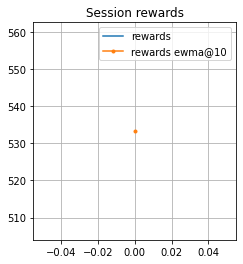

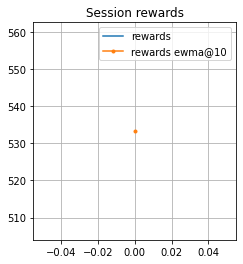

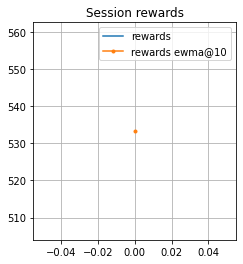

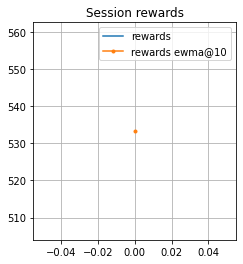

In [19]:
import tqdm
from IPython.display import clear_output

with tqdm.trange(len(entropy_history), 100000) as t:
    for i in t:
        agent_outputs = agent.step(batch_states)
        batch_actions = agent.sample_actions(agent_outputs)
        batch_next_states, batch_rewards, batch_done, _ = env_batch.step(batch_actions)

        # Reward scaling. See above for explanation.
        batch_rewards = batch_rewards * 0.01

        feed_dict = {
            states_ph: batch_states,
            actions_ph: batch_actions,
            next_states_ph: batch_next_states,
            rewards_ph: batch_rewards,
            is_done_ph: batch_done,
        }

        _, ent_t = sess.run([train_step, entropy], feed_dict)
        entropy_history.append(np.mean(ent_t))

        batch_states = batch_next_states

        if i % 500 == 0:
            if i % 2500 == 0:
                rewards_history.append(np.mean(evaluate(agent, env, n_games=3)))
                if rewards_history[-1] >= 5000:
                    print("Your agent has earned the yellow belt")

            clear_output(True)

            plt.figure(figsize=[8, 4])
            plt.subplot(1, 2, 1)
            plt.plot(rewards_history, label='rewards')
            plt.plot(ewma(np.array(rewards_history), span=10), marker='.', label='rewards ewma@10')
            plt.title("Session rewards")
            plt.grid()
            plt.legend()

           

In [ ]:
import gym.wrappers

with gym.wrappers.Monitor(make_env(), directory="videos", force=True) as env_monitor:
    final_rewards = evaluate(agent, env_monitor, n_games=3)

print("Final mean reward:", np.mean(final_rewards))
video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

In [3]:
from google.colab import files
files.download(video_names[-2]) 

NameError: ignored